In [1]:
import numpy as np
from pyscf import fci
import warnings
warnings.filterwarnings("ignore")

Calculate exact Lieb-Wu energies for the Hubbard model

In [2]:
from scipy.integrate import quad
from scipy.special import *

U = np.linspace(1,10,6)
E_LW = []

for Ui in U:
    Ei, err = quad(lambda x: j0(x) * j1(x) / (x * (1 + np.exp(Ui * x / 2))),0, 200)
    E_LW.append(-4*Ei)

Creating Hamiltonian explicitly and solving with FCI for number of orbitals = 4, 6, 8

In [3]:
E = []
t = -1.0
U = np.linspace(1, 10, 6)

norbs = np.linspace(4, 8, 3, dtype=int)

for norb in norbs:
    print("Running FCI for norb = ", norb)
    nelec = (norb//2,norb//2)
    
    # build one-body integral array
    h1 = np.zeros([norb,norb])
    for n in range(norb):
        h1[(n, (n+1)%norb)] = t
    h1 = h1 + h1.T
    
    E_Ui = []
    for Ui in U:
        # build two-body integral array
        h2 = np.zeros((norb,norb,norb,norb))
        for n in range(norb):
            h2[(n,n,n,n)] = Ui

        # calculate energy with FCI
        H_fci = fci.direct_spin1.pspace(h1, h2, norb, nelec, np=4)[1]
        e_all, v_all = np.linalg.eigh(H_fci)

        e, fcivec = fci.direct_spin0.kernel(h1, h2, norb, nelec, nroots=10,
                                            max_space=30, max_cycle=100)
        E_Ui.append(e[0])
    E.append(E_Ui)
    
E = np.array(E)

Running FCI for norb =  4
Running FCI for norb =  6
Running FCI for norb =  8


Compare calculated FCI energies with exact solution

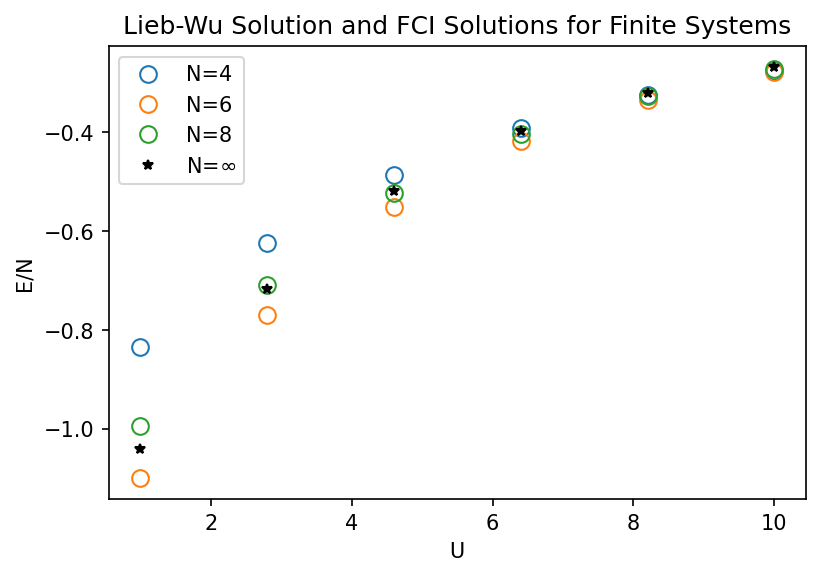

In [4]:
import matplotlib.pyplot as plt
plt.figure(dpi=150)

for e, norb in zip(E, norbs):
    plt.plot(U, np.array(e)/norb, 'o', label=f"N={norb}", mfc='none', markersize=8)

plt.plot(U, E_LW, '*', markersize=5, c='k', label='N=$\infty$')

plt.legend()
plt.ylabel("E/N")
plt.xlabel("U")

plt.title("Lieb-Wu Solution and FCI Solutions for Finite Systems");

Creating Hamiltonian with MoHa and solving with FCI

In [5]:
import sys  
sys.path.insert(0, '../../')
from moha import HamHub

In [6]:
E = []
t = -1.0
U = np.linspace(1, 10, 6)

norbs = np.linspace(4, 8, 3, dtype=int)

for norb in norbs:
    print("Running FCI for norb = ", norb)
    nelec = (norb//2,norb//2)
    
    U=[]
    E_tmp=[]
    for Ui in np.linspace(1,10,6):
        # defining the system
        alpha = 0
        beta = t
        u_onsite = np.array([Ui for i in range(norb + 1)])
        connectivity=[(f"C{i}", f"C{i + 1}", 1) for i in range(1, norb)]\
                    + [(f"C{norb}", f"C{1}", 1)] # 1d chain with pbc
        
        # create PPP hamiltonian object
        hubbard = HamHub(connectivity=connectivity, alpha=alpha, beta=beta, u_onsite=u_onsite)
        
        # build one-body and two-body integral arrays
        h1 = hubbard.generate_one_body_integral(basis='spatial basis', dense=True)
        h2 = hubbard.generate_two_body_integral(basis='spatial basis', dense=True, sym=1)
        
        # calculating energies with FCI
        e, fcivec = fci.direct_spin1.kernel(h1, h2, norb, nelec, nroots=10,
                                            max_space=30, max_cycle=100)
        U.append(Ui)
        E_tmp.append(e[0])
    E.append(E_tmp)
    
E = np.array(E)

Running FCI for norb =  4
Running FCI for norb =  6
Running FCI for norb =  8


Compare calculated FCI energies with exact solution

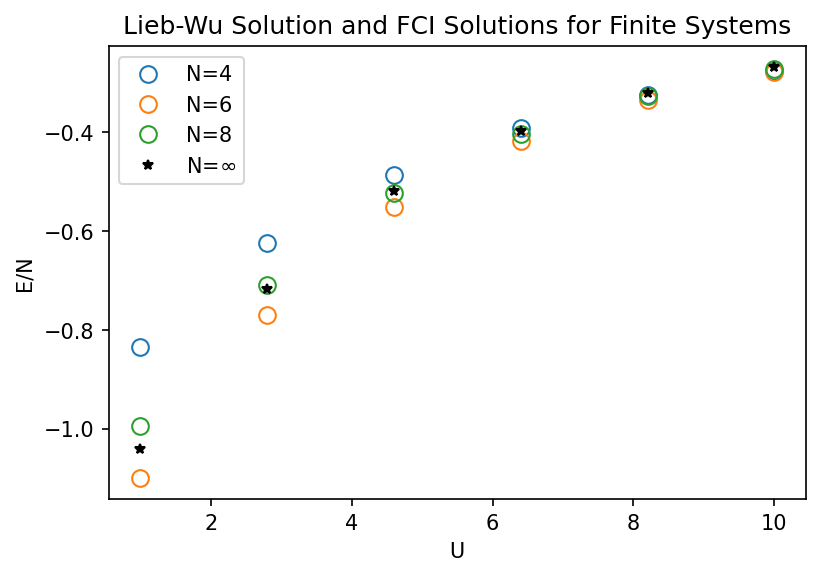

In [8]:
import matplotlib.pyplot as plt
plt.figure(dpi=150)

for e, norb in zip(E, norbs):
    plt.plot(U, np.array(e)/norb, 'o', label=f"N={norb}", mfc='none', markersize=8)

plt.plot(U, E_LW, '*', markersize=5, c='k', label='N=$\infty$')

plt.legend()
plt.ylabel("E/N")
plt.xlabel("U")

plt.title("Lieb-Wu Solution and FCI Solutions for Finite Systems");